In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision.datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

GPU = torch.device(type="cuda")
print(GPU)

cuda


In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root="mnist_dataset",
    download=True,
    train=True,
    transform=ToTensor()
)

5


torch.Size([1, 28, 28])

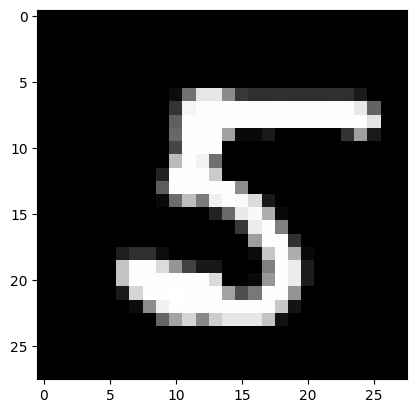

In [13]:
img,label = mnist_dataset[torch.randint(len(mnist_dataset),size=(1,))[0]]

plt.imshow(img.squeeze(),cmap="gray")
print(label)
img.size()

In [6]:
train,val,test = torch.utils.data.random_split(mnist_dataset,[0.8, 0.1, 0.1])

In [1]:
from torch import nn
class image_clasifier_nn(nn.Module):

    def __init__(self):
        super().__init__()
        self.aplanar = nn.Flatten() # Aplana las imágenes
        self.red = nn.Sequential(
            nn.Linear(28*28,15),    #Capa de entrada
            nn.ReLU(),              #Activación de capa entrada
            nn.Linear(15,10),       #Capa profunda intermedia
            nn.Softmax(1)            #Capa de salida softmax
        )



    def forward(self, x):
        x = self.aplanar(x)
        outputs = self.red(x)

        return outputs
    


In [2]:
neural_clasifier = image_clasifier_nn().to(GPU)
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(neural_clasifier.parameters(), lr=0.1)


print(neural_clasifier)

NameError: name 'GPU' is not defined

torch.Size([1, 28, 28])
Categoría real:  0
Predicción:  0


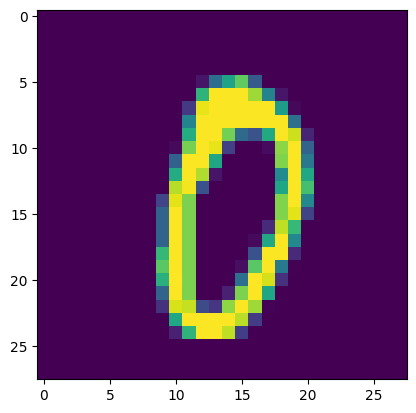

In [9]:
img,lbl = train[torch.randint(len(train),size=(1,))]
plt.imshow(img.squeeze())

img = img.cuda()
print(img.size())

output_logits = neural_clasifier(img)
logits = output_logits[0]
# logits.argmax().tolist()
class_predictect = logits.argmax().tolist()
print("Categoría real: ",lbl)
print("Predicción: ",class_predictect)


In [ ]:
batch_size = 500

train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

12

In [15]:
epochs = 10
learning_rate = 0.15

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(neural_clasifier.parameters(), lr=learning_rate)

In [ ]:
# def train_loop(loader:DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
#     nlotes = len(loader)
#     train_size = len(loader.dataset)

#     model.train()   #Preparo el modelo para el entrenamiento

#     losses = []
#     accuracy = []

#     for nlote,(x,y) in enumerate(loader):
#         x = x.cuda()
#         y = y.cuda()

#         # Forward Pass
#         logits = model(x)

#         # Backpropagation
#         loss = loss_fn(logits,y)  #Calculo de loss
#         loss.backward()             #Calculo de gradiente
#         optimizer.step()            #Actualización de parámetros
#         optimizer.zero_grad()       #Limpieza del optimizador

#         #Guardamos algunas caractgerísticas para plotear al final
#         losses.append(loss.item())  
#         accuracy.append((logits.argmax(1)==y).type(torch.float).sum().item()/train_size)

#         #Muestra del proceso
#         if nlote % 10 == 0:
#             print("Nº de lote: ",nlote)
#             print("Loss: ",loss.item())
#             print(f"Accuracy: {accuracy[-1]*100:2f}%")
#             print()

#     plt.figure()
#     plt.title("Evolución de loss")
#     plt.plot(range(nlotes),losses)

#     plt.figure()
#     plt.title("Evolución de precisión")
#     plt.plot(range(nlotes),accuracy)

#     return losses, accuracy

In [12]:
def train_loop(loader:DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses, train_accuracy = 0,0

    for nlote,(x,y) in enumerate(loader):
        x = x.cuda()
        y = y.cuda()

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,y)  #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()
        train_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses /= nlotes
    train_accuracy /= train_size
    
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")

In [ ]:
# def val_loop(loader:DataLoader, model:nn.Module, loss_fn:callable):
    
#     val_size = len(loader.dataset)
#     nlotes = len(loader)

#     model.eval()         #Preparo el modelo para inferencia

#     val_losses, val_accuracy = [],[]

#     with torch.no_grad():       #Calcelo el calculo del gradiente
#         for x,y in loader:
            
#             x,y = x.to(GPU), y.to(GPU)

#             logits = model(x)       # Inferencia
            
#             val_losses.append(loss_fn(logits,y).item())
#             val_accuracy.append((logits.argmax(1)==y).type(torch.float).sum().item()/val_size)

#     mean_loss = sum(val_losses)/nlotes
#     mean_acc = sum(val_accuracy)/val_size

#     plt.figure()
#     plt.title("Evolución de loss")
#     plt.plot(range(nlotes),val_losses)

#     plt.figure()
#     plt.title("Evolución de precisión")
#     plt.plot(range(nlotes),val_accuracy)

#     return val_losses, mean_loss, val_accuracy, mean_acc

In [13]:
def val_loop(loader:DataLoader, model:nn.Module, loss_fn:callable):
    
    val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses, val_accuracy = 0,0

    with torch.no_grad():       #Calcelo el calculo del gradiente
        for x,y in loader:
            
            x,y = x.to(GPU), y.to(GPU)

            logits = model(x)       # Inferencia
            
            val_losses += loss_fn(logits,y).item()
            val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes
    val_accuracy /= val_size

    print(f"\t\tValidación: {(100*val_accuracy):>0.1f}% / {val_losses:>8f}")



In [17]:
for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    train_loop(train_loader,neural_clasifier,optimizer,loss)

    #Validation
    val_loop(val_loader,neural_clasifier,loss)

print("Finalizado entrenamiento del modelo!")

Itenración: 1 / 10 -----------------------------
Nº de lote:  0
Loss:  1.5858449935913086
Nº de lote:  10
Loss:  1.5712060928344727
Nº de lote:  20
Loss:  1.5990848541259766
Nº de lote:  30
Loss:  1.5766392946243286
Nº de lote:  40
Loss:  1.5642527341842651
Nº de lote:  50
Loss:  1.5768204927444458
Nº de lote:  60
Loss:  1.5803248882293701
Nº de lote:  70
Loss:  1.6101765632629395
Nº de lote:  80
Loss:  1.5605098009109497
Nº de lote:  90
Loss:  1.576385259628296

	Accuracy/Loss Promedio
		Entrenamiento: 90.1% / 1.580514
		Validación: 89.5% / 1.581088
Itenración: 2 / 10 -----------------------------
Nº de lote:  0
Loss:  1.5813792943954468
Nº de lote:  10
Loss:  1.5629220008850098
Nº de lote:  20
Loss:  1.5900763273239136
Nº de lote:  30
Loss:  1.5814287662506104
Nº de lote:  40
Loss:  1.5793368816375732
Nº de lote:  50
Loss:  1.5948680639266968
Nº de lote:  60
Loss:  1.5828392505645752
Nº de lote:  70
Loss:  1.5607964992523193
Nº de lote:  80
Loss:  1.5723761320114136
Nº de lote:  90
L

Categoría real:  3
Predicción:  8


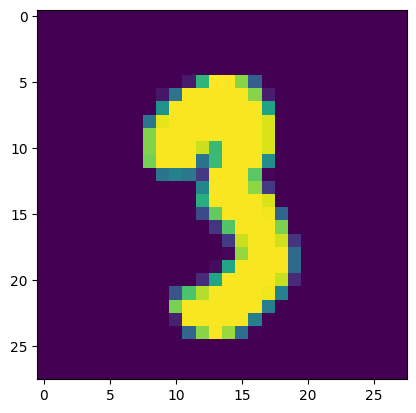

In [73]:
img,lbl = test[torch.randint(len(test),size=(1,))]

img = img.cuda()
img.is_cuda

logits = neural_clasifier(img)

plt.imshow(img.cpu().squeeze())
print("Categoría real: ",lbl)
print("Predicción: ",logits.argmax(1).item())